<a href="https://colab.research.google.com/github/RDW287/CM3710-Coding-Assessment/blob/main/AI_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/RDW287/CM3710-Coding-Assessment
%cd CM3710-Coding-Assessment/
!git pull

fatal: destination path 'CM3710-Coding-Assessment' already exists and is not an empty directory.
/content/CM3710-Coding-Assessment
Already up to date.


#**Introduction**

The aim of this notebook is to create and compare to two AI algorithms to classify images from the selected dataset. The dataset is images captured using Meta glass, these include rooms and objects within RGU that are categorized/labelled by name.

In [1]:
# Required imports for code
import os
import re
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from PIL import Image
from tensorflow import random, keras
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import svm

No. Images:  40
Image Size: (360, 360)


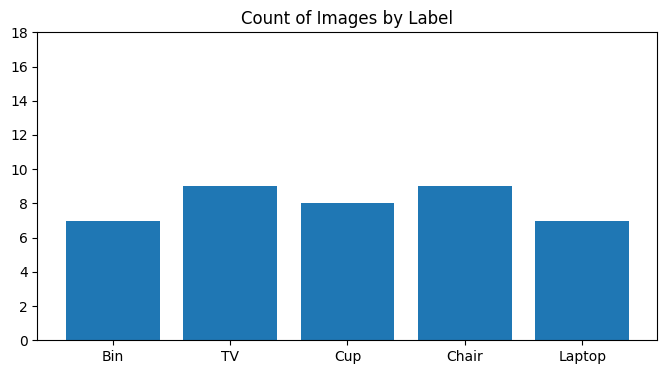

In [4]:
# Data Exploration

directory = "RGU_Images" #The name of the folder containing the images

# Stores the names of the files, this will be used as the labels later
image_filenames = []
files = []
for file in os.listdir(directory):
  name = re.split('_|-', file) #Splits file names by _ and - to get the label as the names are like 1-Bin_1.jpeg
  if name[1] in ("Cup", "TV", "Bin", "Chair", "Laptop"): #We are only looking at the objects rather than the rooms
    image_filenames.append(name[1])
    files.append(file)

# We can see that we have 40 images that are 360x360 pixels in size
print("No. Images: ", len(files))
print("Image Size:", Image.open(f'{directory}/{files[0]}').size)

# Gets the count of each label in the dataset
filename_count = Counter(image_filenames)

# The bar graph below shows that each category has between 7 and 9 images for each, this isnt a large dataset so image augmentation will be required to increase it.
plt.figure(figsize=(8,4))
plt.bar(filename_count.keys(), filename_count.values())
plt.yticks(range(0,20,2))
plt.title("Count of Images by Label")
plt.show()

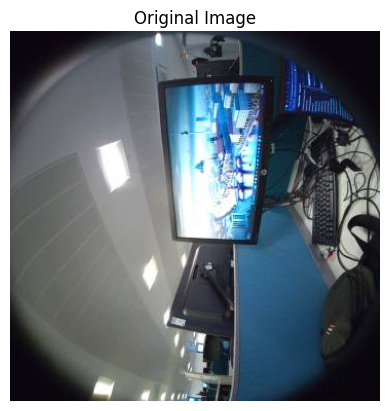

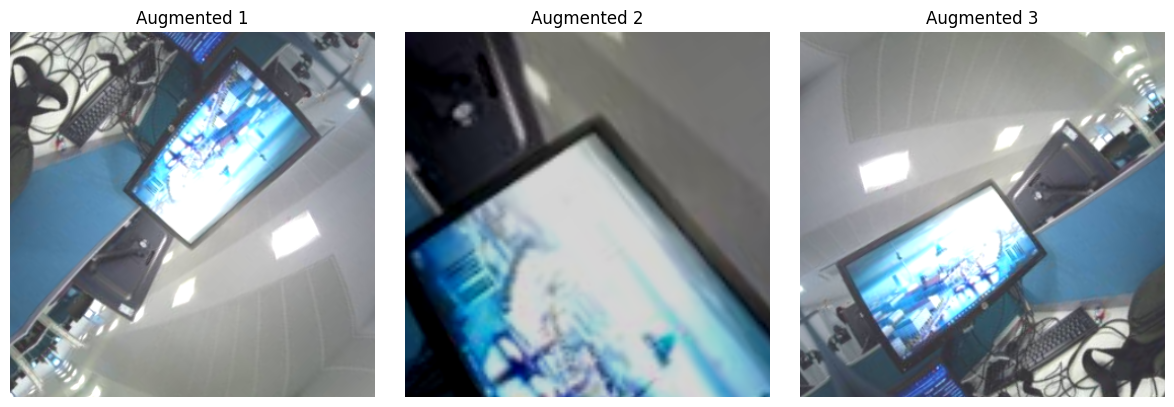

In [5]:
# Data Preprocessing

# We will create a keras layer to apply augmentation techniques to expand our training set
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical", seed=1), #Flips the image horizontally and/or vertically
    keras.layers.RandomRotation(0.5, seed=1), #Adds some rotation to the image
    keras.layers.RandomZoom((-0.75,0), seed=1), #Zooms into a particular point by 0% - 75% allowing it to learn patterns in small areas of the image
    keras.layers.RandomBrightness(factor=0.2, seed=1), #Changes the brightness of the image
    keras.layers.Rescaling(1./255.) #This will scale the image contents to between 0-1, this is min-max normalisation
])

# This is what the original image looks like
img = plt.imread(f'{directory}/{files[1]}')
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()

# These are examples of how the images will look after augmentation
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    augmented = data_augmentation(img)
    axs[i].imshow(augmented)
    axs[i].set_title(f"Augmented {i + 1}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Now we need to create our dataset with the augmented images
images = []
for file in files:
  image = Image.open(f'{directory}/{file}')
  images.append(np.array(image))
images = np.array(images) #We will use a numpy array for compatability with future methods

# We need to convert the labels from the file names into one-hot vectors, it will create an n length array with 0 in every column apart from the one where it matches the label
y_categorical = keras.utils.to_categorical(
    np.unique(image_filenames, return_inverse=True)[1]
)
print("Categorical Vector Example:", y_categorical[0])

# A train test split will be used to leave 40% of the training set as unseen data for testing. This prevents overfitting of the model and allows us to test its suitability on unseen images
X_train, X_test, y_train, y_test = train_test_split(
    images,
    y_categorical,
    test_size=0.4, #40% of the entire dataset is set aside, this will not include augmented images as this would cause accuracy overestimation due to small parts of the training data being in the test set
    stratify=y_categorical, #This is a sampling method to help preserve the proportions in our data, it prevents certain low occurring categories not appearing in our test at all
    random_state=1 #Sets a seed so split is the same for everyone who runs this
)

# Now we need to add in our augmented data into our training set, we did this after the split to prevent pieces of training data sneaking into our test set
for x,y in zip(X_train, y_train):
  for j in range(10): #We will create 10 augmented images for each image in our training set, this may take a couple minutes
    augmented = np.array(data_augmentation(x))
    X_train = np.append(X_train, [augmented], axis=0)
    y_train = np.append(y_train, [y], axis=0)

print("New Training Set Size: ", len(X_train))

Categorical Vector Example: [1. 0. 0. 0. 0.]
New Training Set Size:  264


In [ ]:
# Algorithm 1 - Convolutional Neural Network (CNN)

CNN = keras.models.Sequential([
    keras.Input(shape=(360,360,3)), #Specifies that the image is 360x360
    # 1st Convolution block
    keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu'), #The convolution layer will have 16 3x3 filters
    keras.layers.MaxPooling2D(pool_size=(2,2)), #The pooling layer will summarise the image in 2x2 sections

    # 2nd Convolution block
    keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    # 3rd Convolution block
    keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    # 4th Convolution block
    keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Flatten(), #Turns the image from a nested array into a vector
    keras.layers.Dense(len(y_categorical[0]), activation="softmax"), #The softmax function in the output layer will weight the probability of the image being one of the classes
])

# We will fit the training data to the model, "adam" uses stochastic gradient descent to optimize the network
CNN.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
CNN.fit(X_train, y_train, epochs=10) #10 Epochs means it will run over the full training set 10 times

In [ ]:
# We can then test our model on the test set
score = CNN.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0]) #Let's look at loss
print("Test accuracy:", score[1]) #And accuracy

In [ ]:
# Algorithm 2 - Support Vector Machine (SVM)
svc = svm.SVC(probability=True)
SVM = GridSearchCV(
    svc,
    {'C':[0.1,1,10],'gamma':[0.1,1],'kernel':['rbf','poly']}
)

SVM.fit(X_train.reshape(264, 3*360*360), np.argmax(y_train, axis=1))
print(SVM.best_params_)

In [ ]:
# Testing the model using the testing data
y_pred = SVM.predict(X_test)

# Calculating the accuracy of the model
accuracy = accuracy_score(y_pred, y_test)

# Print the accuracy of the model
print(f"The model is {accuracy*100}% accurate")